In [0]:
import os
os.chdir("Documents\\Fall 2019\\ISYE 4133\\Project")

In [0]:
import pandas as pd
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt

file = "1T1.DAT"
path = "data_vrp_time_windows/"
cap = 100
def read_vrptw(location, branchLimit = None):
  with open(location,"r") as fin:
    data = [item.split() for item in fin.readlines()]
  df = pd.DataFrame(data, columns = ["Node","X","Y","Open 1","Close 1","Open 2","Close 2", "Demand", "Service Time","Delivery/Pickup"], dtype = np.int64)
  if branchLimit == None:
    return df
  else:
    return df[df["Node"] <= branchLimit]

def showFacilities(df):
  plt.scatter(df[df["Node"]>0]["X"],df[df["Node"]>0]["Y"],c="b")
  for i in df[df["Node"]>0]["Node"]:
    plt.annotate('$q_%d=%d$'%(i,df[df["Node"]==i]["Demand"]),(df[df["Node"]== i]["X"]+2,df[df["Node"] == i]["Y"]))
  plt.plot(df[df["Node"]==0]["X"],df[df["Node"]==0]["Y"],c="r",marker="s")
  plt.show()

def showRoutes(df,route_dic=None,active_arcs = None,file=None):
  plt.scatter(df[df["Node"]>0]["X"],df[df["Node"]>0]["Y"],c="b")
  # for i in df[df["Node"]>0]["Node"]:
  #   plt.annotate('$q_%d=%d$'%(i,df[df["Node"]==i]["Demand"]),(df[df["Node"]== i]["X"]+2,df[df["Node"] == i]["Y"]))
  colors = ["g","b","r","y","c","k","m"]
  if route_dic != None:
    col=0
    for route in route_dic:
      active_arcs = route
      for i,j in active_arcs:
        plt.plot([int(df[df["Node"]==i]["X"]),int(df[df["Node"]==j]["X"])],[int(df[df["Node"]==i]["Y"]),int(df[df["Node"]==j]["Y"])],c=colors[col%7],alpha=0.3)
      col+=1
  else:
    for i,j in active_arcs:
        plt.plot([int(df[df["Node"]==i]["X"]),int(df[df["Node"]==j]["X"])],[int(df[df["Node"]==i]["Y"]),int(df[df["Node"]==j]["Y"])],c="g",alpha=0.3)
  plt.plot(df[df["Node"]==0]["X"],df[df["Node"]==0]["Y"],c="r",marker="s")
  
    
  plt.plot(df[df["Node"]==0]["X"],df[df["Node"]==0]["Y"],c="r",marker="s")
  plt.savefig(file)
  plt.show()
  

def euclidian_dist(df):
    return np.round(np.sqrt((pd.to_numeric(df["X"])-pd.to_numeric(df["X.1"]))*(pd.to_numeric(df["X"])-pd.to_numeric(df["X.1"])) + (pd.to_numeric(df["Y"])-pd.to_numeric(df["Y.1"]))*(pd.to_numeric(df["Y"])-pd.to_numeric(df["Y.1"]))))
df = read_vrptw(path+file,branchLimit=11)
branches = [node for node in df.Node if node > 0]

In [0]:

nodes_1 = df[["Node","X","Y"]].copy(deep=True)
nodes_1.columns = ["Node.1","X.1","Y.1"]
distance_df = pd.DataFrame([(i,j) for i in df.Node for j in df.Node if i != j], columns = ["Node","Node.1"])
distance_df = distance_df.merge(nodes_1,on="Node.1")
distance_df = distance_df.merge(df[["Node","X","Y"]],on="Node")
distance_df.sort_values(axis =0, by=["Node","Node.1"],inplace=True)
distance_df["Distance"] = euclidian_dist(distance_df)

arcs, distance = multidict({(item[0],item[1]) : [item[2]] for item in zip(distance_df["Node"],distance_df["Node.1"],distance_df["Distance"])})
node_list, openTimes, closeTimes, demand = multidict({item[0]:[item[1],item[2],item[3]] for item in zip(df["Node"],df["Open 1"],df["Close 1"],df["Demand"])})
M = tupledict({(i,j):max(closeTimes[i] + distance[i,j] - openTimes[j],0) for (i,j) in arcs})

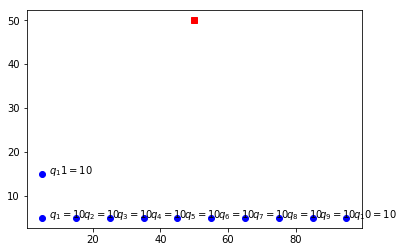

In [13]:
showFacilities(df)

In [14]:
m = Model("VRPTW")

flow = m.addVars(arcs,vtype = GRB.BINARY,name="flow")
q = m.addVars(node_list,vtype = GRB.CONTINUOUS, ub = 100, name="q")
h = m.addVars(node_list,vtype = GRB.CONTINUOUS,lb=openTimes, ub=closeTimes, name="h")

m.addConstrs(flow.sum(i,"*") == 1 for i in df.Node if i > 0)
m.addConstrs(flow.sum("*",j) == 1 for j in df.Node if j > 0)
m.addConstrs(flow.sum(i,"*") == flow.sum("*",i) for i in df.Node)
m.addConstrs(h[i] + distance[i,j]/3 - h[j] <= (1-flow[i,j])*M[i,j] for (i,j) in arcs if j > 0)
m.addConstrs(q[i] + demand[j] - q[j] <= (1-flow[i,j])*cap for (i,j) in arcs if j>0)


obj = flow.prod(distance)
m.setObjective(obj,GRB.MINIMIZE)
m.optimize()

active_arcs = [(item) for item,val in flow.items() if val.X != 0]

Optimize a model with 276 rows, 156 columns and 1232 nonzeros
Variable types: 24 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 9e+01]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 548.0000000
Presolve removed 11 rows and 2 columns
Presolve time: 0.01s
Presolved: 265 rows, 154 columns, 1945 nonzeros
Variable types: 22 continuous, 132 integer (132 binary)

Root relaxation: objective 1.152000e+02, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  115.20000    0   18  548.00000  115.20000  79.0%     -    0s
H    0     0                     434.0000000  115.20000  73.5%     -    0s
H    0     0                     314.0000000  115.20000  63.3%     -    0s
     0     0  132.20000    0   25  314.00000  132.20000  57.9% 

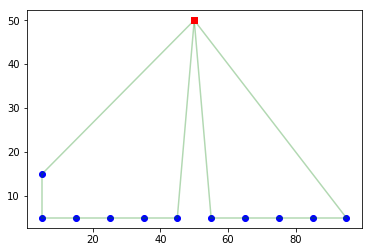

In [15]:
showRoutes(df,active_arcs=active_arcs,file = "VRPTW11NodeFlowForm")

# Column Generation VRPTW

Generating Feasible Subset

In [0]:
subset_dict = tupledict({arc:[] for arc in arcs})
route_cost = tupledict({})
for node in [node for node in df.Node if node > 0]:
    to_include = arcs.select(0,node) + arcs.select(node,0)
    route_cost[node-1] = (np.sum(distance[arc] for arc in to_include))
    for arc in arcs:
        subset_dict[arc].append(1) if arc in to_include else subset_dict[arc].append(0)

In [5]:
ind = True
count = 1
while ind:
  m = Model("Column Generation VRP")
  m.params.outputFlag = 0
  X = m.addVars(len(route_cost),vtype=GRB.CONTINUOUS,name="X")
  m.addConstrs(quicksum(np.dot(subset_dict.select("*",node),X.values())) == 1 for node in branches) #flow into each branch is one over all patterns... means we visit each branch once
  obj = X.prod(route_cost) 
  m.setObjective(obj,GRB.MINIMIZE)
  m.optimize()
  

  #i think the error is in here or in the creation of the objective value below
  y = [con.getAttr("Pi") for con in m.getConstrs()]
  #print(y)
  reduced_branch_cost = {a:b for (a,b) in zip(branches,y)}
  reduced_branch_cost[0] = 0 ## We don't end up with a Pi for the first branch.... so i made up that it should be 0
  reduced_cost = tupledict({(i,j): distance[i,j] - reduced_branch_cost[j] for (i,j) in arcs}) #is it - reduced_branch_cost[i] or j?

  n = Model("Pricing Problem")
  n.params.outputFlag = 0
  n.params.TimeLimit = 40
  n.params.PoolSearchMode = 0
  n.params.PoolSolutions = 20
  n.params.Heuristics = .5

  flow = n.addVars(arcs,vtype=GRB.BINARY,name="flow")
  q = n.addVars(df.Node,vtype=GRB.CONTINUOUS,ub=cap,name="q")
  h = n.addVars(node_list,vtype = GRB.CONTINUOUS,lb=openTimes, ub=closeTimes, name="h")
  obj = flow.prod(reduced_cost)#"*",branches) #this excludes the reduced of the arcs connecting to the depot... I need to include the cost of those arcs somehow tho
  
  n.addConstr(flow.sum(0,"*") == 1)
  n.addConstr(-1*flow.sum("*",0) == -1)
  n.addConstrs(flow.sum(i,"*") == flow.sum("*",i) for i in branches)
  n.addConstrs(cap*(1-flow[i,j]) >= q[i] + demand[j] - q[j] for (i,j) in arcs if j>0) #arbitrarily added if j > 1 and it worked.
  n.addConstrs(h[i] + distance[i,j]/3 - h[j] <= (1-flow[i,j])*M[i,j] for (i,j) in arcs if j > 0)

  n.setObjective(obj,GRB.MINIMIZE)
  n.optimize()

  print([(item,val.X) for item,val in flow.items() if val.X !=0], max(route_cost.keys())+1,n.ObjVal, m.ObjVal)
  count += 1
  
  #adding the found solutions back into the fesaible set
  if (n.objVal >= 0 or count>50):
    ind = False 
  else:
    for x in range(n.solCount):
      n.params.SolutionNumber = x
      all_vars = n.Xn
      flows = all_vars[:len(arcs)]
      zipped = tupledict({arc:flow for (arc,flow) in zip(arcs,flows)})
      if zipped.prod(reduced_cost) <= 0:
        for (arc,val) in zipped.items():
          subset_dict[arc].append(val)
        route_cost[max(route_cost.keys()) + 1] = zipped.prod(distance)#(np.sum(zipped[arc]*distance[arc] for arc in arcs))


Academic license - for non-commercial use only
[((0, 11), 1.0), ((1, 2), 1.0), ((2, 4), 1.0), ((4, 5), 1.0), ((5, 7), 1.0), ((6, 8), 1.0), ((7, 6), 1.0), ((8, 9), 1.0), ((9, 0), 1.0), ((11, 1), 1.0)] 11 -716.0 1170.0
[((0, 10), 1.0), ((1, 0), 1.0), ((3, 1), 1.0), ((4, 3), 1.0), ((7, 4), 1.0), ((8, 7), 1.0), ((9, 8), 1.0), ((10, 9), 1.0)] 20 -236.0 454.0
[((0, 2), 1.0), ((2, 3), 1.0), ((3, 4), 1.0), ((4, 5), 1.0), ((5, 7), 1.0), ((7, 9), 1.0), ((9, 10), 1.0), ((10, 0), 1.0)] 29 -245.0 377.99999999999994
[((0, 11), 1.0), ((1, 2), 1.0), ((2, 3), 1.0), ((3, 6), 1.0), ((6, 7), 1.0), ((7, 9), 1.0), ((9, 10), 1.0), ((10, 0), 1.0), ((11, 1), 1.0)] 40 -158.28 356.47999999999996
[((0, 10), 1.0), ((1, 11), 1.0), ((3, 1), 1.0), ((4, 3), 1.0), ((5, 4), 1.0), ((6, 5), 1.0), ((8, 6), 1.0), ((9, 8), 1.0), ((10, 9), 1.0), ((11, 0), 1.0)] 47 -132.43243243243242 332.13513513513516
[((0, 10), 1.0), ((2, 11), 1.0), ((3, 2), 1.0), ((4, 3), 1.0), ((5, 4), 1.0), ((7, 5), 1.0), ((8, 7), 1.0), ((10, 8), 1.0), (

In [0]:
f = Model("Column Generation VRP")
f.params.outputFlag = 0
pats = f.addVars(len(route_cost),vtype=GRB.BINARY,name="X")
f.addConstrs(quicksum(np.dot(subset_dict.select("*",node),pats.values())) == 1 for node in branches) #flow into each branch is one over all patterns... means we visit each branch once
obj = pats.prod(route_cost) 
f.setObjective(obj,GRB.MINIMIZE)
f.optimize()

In [7]:
f.ObjVal

303.0

In [0]:
def getAllPatterns(subset_dict,route_cost):
  small = pd.DataFrame.from_dict(subset_dict,orient="index")
  small = small.reset_index()
  small = small.rename(columns={"index":"Arc"})
  new_dict = {}
  for (key,val) in route_cost.items():
    try:
      new_dict[key] = val.getValue()
    except:
      new_dict[key] = val
  small = small.append(pd.Series(new_dict),ignore_index=True)
  return small
'''
Params:
pats - the X var from the final Integer program run after completion of column generation
subset_dict - the subset dictionary which was passed into master Lp at each iteration
route_cost - the cost of each pattern

Returns:
large_active_arcs: the set of all active acrs which can be passed into showRoutes
smallier - a datafram comtaining all the patterns used and their corresponding costs
'''
def getUsedPatterns(pats,subset_dict,route_cost):
  little_boy = [var for var in pats.values() if var.X > 0]
  index_list = [int(item.varName[2:-1]) for item in little_boy]
  final_pats = np.array(subset_dict.values())[:,index_list]
  patterns_taken = {arc:row for (arc,row) in zip(arcs,final_pats)}
  active_dic={arc:np.sum(row) for (arc,row) in zip(arcs,final_pats)}
  large_active_arcs = [(item) for item,val in active_dic.items() if val != 0]
  smallier = pd.DataFrame.from_dict(patterns_taken,orient="index",columns=index_list)
  smallier = smallier.reset_index()
  smallier = smallier.rename(columns={"index":"Arc"})
  smallier = smallier.append(pd.Series({index:route_cost[index] for index in index_list}),ignore_index=True)
  

  return large_active_arcs,smallier,patterns_taken
big = getAllPatterns(subset_dict,route_cost)
col_active_arcs,small,patterns_taken = getUsedPatterns(pats,subset_dict, route_cost)

patterns_taken_list = multidict(patterns_taken)[1:]
new_list = []
for item in patterns_taken_list:
   new_list.append([(key) for (key,value) in item.items() if value > 0])

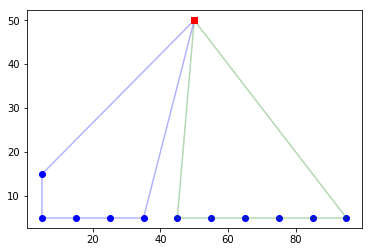

In [9]:
showRoutes(df,route_dic=new_list,file="VRPTW 10 Node Patterns.png")

In [18]:
pic.savefig("VRPTW 100 Node Routes.png")

<Figure size 432x288 with 0 Axes>